In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, ValidationCurveDisplay, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    make_scorer
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X, y, metadata, variables = get_data('census_income')

In [3]:
# Remove nulls

# Replace ? with np.nan
X.replace({'workclass': {'?': np.nan},
           'occupation': {'?': np.nan},
           'native-country': {'?': np.nan}}, 
           inplace=True)

r, _ = np.where(pd.isnull(X))

idx = [i for i in range(X.shape[0]) if i not in r]
X = X.iloc[idx, :]
y = y.iloc[idx, :]

In [4]:
# Filter to USA and remove columns capital-loss, capital-gain
r = np.where(X['native-country']=='United-States')
X = X.iloc[r[0], :].copy()
y = y.iloc[r[0], :].copy()

excl_col = ['native-country', 'capital-loss', 'capital-gain']
X.drop(columns=excl_col, inplace=True)


In [5]:

variables = variables.query('name not in @excl_col')

In [6]:
y.replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)
y.value_counts(normalize=True)

income
<=50K     0.746973
>50K      0.253027
Name: proportion, dtype: float64

In [7]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [8]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                age
2             fnlwgt
4      education-num
12    hours-per-week
Name: name, dtype: object

In [9]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']

cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

1         workclass
3         education
5    marital-status
6        occupation
7      relationship
8              race
9               sex
Name: name, dtype: object

# Train KNN

In [10]:

RANDOM_STATE = 42
N_FOLDS = 5
N_JOBS = -1
SCORING = 'accuracy'
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    ('scale', MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
    ],
    remainder='drop',
    n_jobs=N_JOBS)

clf = KNeighborsClassifier(n_jobs=N_JOBS)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])



## Tune the KNN

In [11]:
cv_scores = []

grid_params = {
        'n_neighbors': {'model__n_neighbors': [5, 10, 20, 30, 40, 50, 75, 100]}, 
        'metric': {'model__metric':['minkowski', 'manhattan', 'euclidean']},
    }
for key, grid_param in grid_params.items():
    print('------------------', key, '------------------')
    
    gs = GridSearchCV(clf_pipeline, grid_param, 
                      cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
    gs.fit(X_train, y_train.values.ravel())

    cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
                                   'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
                                   'mean_test_score': gs.cv_results_['mean_test_score'],
                                   'mean_train_score': gs.cv_results_['mean_train_score'],
                                   }))

cv_scores = pd.concat(cv_scores)

------------------ n_neighbors ------------------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
------------------ metric ------------------
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


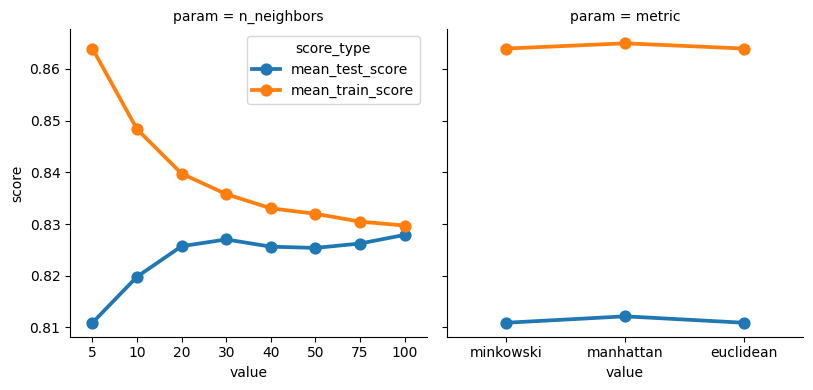

In [12]:
cv_scores_melt = cv_scores.melt(id_vars=['param', 'value'], value_vars=['mean_test_score', 'mean_train_score'], var_name='score_type', value_name='score')
sns.FacetGrid(cv_scores_melt, col='param', hue='score_type', col_wrap=3, height=4, sharex=False, legend_out=False).map(sns.pointplot, 'value', 'score').add_legend()

In [13]:
grid_params = {
        'model__n_neighbors': np.arange(30, 75, 5), 
        'model__metric':['minkowski', 'manhattan', 'euclidean'],
    }

gs = GridSearchCV(clf_pipeline, grid_params, 
                    cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
gs.fit(X_train, y_train.values.ravel())

print("Best Score of train set: "+str(gs.best_score_))
print("Best parameter set: "+str(gs.best_params_))
print("Test Score: "+str(gs.score(X_test,y_test)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
gs.best_estimator_['model']

In [ ]:
import joblib
joblib.dump(value=gs, filename='./model/knn_census_income_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/knn_census_income_best.pkl', compress=True)

In [ ]:

# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

In [ ]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

In [ ]:

# # https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

# common_params = {
#     "X": X_train,
#     "y": y_train,
#     "train_sizes": np.linspace(0.1, 1.0, 10),
#     "cv": N_FOLDS,
#     "score_type": "both",
#     "n_jobs": N_JOBS,
#     "line_kw": {"marker": "o"},
#     "std_display_style": "fill_between",
#     "score_name": SCORING,
# }

# for ax_idx, estimator in enumerate([clf_pipeline]):
#     LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
#     handles, label = ax[ax_idx].get_legend_handles_labels()
#     ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
#     ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['<=50K', '>50K'], cmap='Blues')

In [ ]:

scores = {'accuracy_score':accuracy_score(y_test, y_test_predictions),
          'precision_score':precision_score(y_test, y_test_predictions, pos_label='>50K'),
          'recall_score':recall_score(y_test, y_test_predictions, pos_label='>50K'),
          'f2_score':fbeta_score(y_test, y_test_predictions, beta=2, pos_label='>50K')
}

print(scores)


In [ ]:

# target_names=target_names
print(classification_report(y_test, y_test_predictions))


In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gs, X_test, y_test, )
plt.show()

In [ ]:
# # plot precison recall curve
# import matplotlib.pyplot as plt
# from sklearn.metrics import (precision_recall_curve,
#                               PrecisionRecallDisplay)

# precision, recall, _ = precision_recall_curve(y_test, y_test_predictions, pos_label='>50K')
# disp = PrecisionRecallDisplay(precision=precision, recall=recall)
# disp.plot()
# plt.show()